<a href="https://colab.research.google.com/github/Ravio1i/ki-lab/blob/master/0_Simple_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Simple Neural Network with PyTorch. Original source can be found [here](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html).

In [65]:
import torch
import torch.nn.functional as F
from torch import optim 
import torchvision
import matplotlib.pyplot as plt
from time import time
print(torch.__version__)
print(torchvision.__version__)

1.8.0+cu101
0.9.0+cu101


# Network

In [50]:
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in: int, H: int, D_out: int):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
          D_in (int): input dimenstion
          H (int): hidden dimension
          D_out (int): output dimension
        """
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        # Relu von pytorch
        h_relu = F.relu(self.linear1(x))
        #h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return F.log_softmax(y_pred)

# DATA LOADER

In [51]:
#!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
#!tar -zxvf MNIST.tar.gz
n_epochs = 50
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 30

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.QMNIST('/files/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize((0.1307,), (0.3081,))
                              ])),
    batch_size=batch_size_train, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.QMNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True
)


# PRE

In [52]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)
#print(batch_idx)
#print(example_data)
#print(example_targets)

torch.Size([1000, 1, 28, 28])


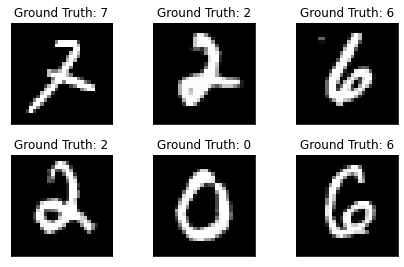

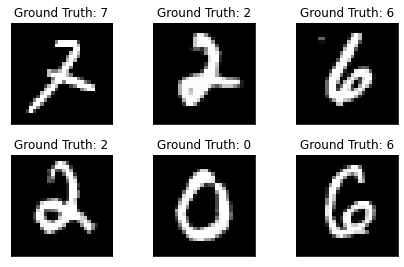

In [53]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [54]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
#batch_size = 64
input_size = 784
hidden_size = 100
output_size = 10

# get data and labels from train_loader
x, y = next(iter(train_loader))

# Flatten tensor
print(x.shape)

torch.Size([64, 1, 28, 28])


# Train

In [59]:
def train(epoch: int, criterion: torch.nn.functional, optimizer: torch.optim):
    """Forward pass: Compute predicted y by passing x to the model
    """ 
    for batch_idx, (x, y) in enumerate(train_loader):
      #x.to(device)
      #y.to(device)
      x = x.view(x.shape[0], -1)
      optimizer.zero_grad()
      y_pred = model(x)
      
      # Compute and print loss
      loss = criterion(y_pred, y)
      loss.backward()
      optimizer.step()

      if batch_idx % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(x), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))
        train_losses.append(loss.item())
        train_counter.append(
          (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

# Test

In [56]:
def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for x, y in test_loader:
      x = x.view(x.shape[0], -1)
      y_hat = model(x)
      test_loss += F.nll_loss(y_hat, y, size_average=False).item()
      pred = y_hat.data.max(1, keepdim=True)[1]
      correct += pred.eq(y.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
def run(device_name: str, input_size: int, hidden_size: int, output_size: int):
    input_size = input_size
    hidden_size = hidden_size
    output_size = output_size

    # INITIATE VARIABLE
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

    device = torch.device(device_name)
    model = TwoLayerNet(input_size, hidden_size, output_size)
    model.to(device)
    criterion = F.nll_loss
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

    # TRAIN
    time_start = time()
    test()
    for epoch in range(1, n_epochs + 1):
      train(epoch, criterion, optimizer, device)
      test()

    print("\nTraining Time (in minutes) =",(time()-time_start)/60)

# CPU

In [64]:
# Construct our model by instantiating the class defined above
# TRAIN WITH CPU
device = torch.device('cpu')
model = TwoLayerNet(input_size, hidden_size, output_size)
model.to(device)
criterion = F.nll_loss
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

# INITIATE VARIABLE
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

# TRAIN
time_start = time()
test()
for epoch in range(1, n_epochs + 1):
  train(epoch, criterion, optimizer, device)
  test()

print("\nTraining Time (in minutes) =",(time()-time_start)/60)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.2825, Accuracy: 8645/60000 (14%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.223202
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.275507
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.240805
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.266383
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.305159
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.253046
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.301046
Train Epoch: 1 [13440/60000 (22%)]	Loss: 2.251309
Train Epoch: 1 [15360/60000 (26%)]	Loss: 2.229656
Train Epoch: 1 [17280/60000 (29%)]	Loss: 2.220941
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.212251
Train Epoch: 1 [21120/60000 (35%)]	Loss: 2.201715
Train Epoch: 1 [23040/60000 (38%)]	Loss: 2.225480
Train Epoch: 1 [24960/60000 (42%)]	Loss: 2.185395
Train Epoch: 1 [26880/60000 (45%)]	Loss: 2.226004
Train Epoch: 1 [28800/60000 (48%)]	Loss: 2.248311
Train Epoch: 1 [30720/60000 (51%)]	Loss: 2.196216
Train Epoch: 1 [32640/60000 (54%)]	Loss: 2.186674
Train Epoch: 1 [34560/60000 (58%)]	Loss: 2.184103
Trai

# GPU (CUDA)

In [63]:
# TRAIN WITH CUDA
device = torch.device("cuda")
model = TwoLayerNet(input_size, hidden_size, output_size)
model.to(device)

# INITIATE VARIABLE
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

time_start = time()

# TRAIN
#test()
for epoch in range(1, n_epochs + 1):
  train(epoch, criterion, optimizer, device)
  test()

print("\nTraining Time (in minutes) =",(time()-time_start)/60)

RuntimeError: ignored

# Hidden Layers

Streaming output truncated to the last 5000 lines.


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        ...,


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -

KeyboardInterrupt: ignored

# PLOT

[0, 60000, 120000, 180000, 240000, 300000, 360000, 420000, 480000, 540000, 600000, 660000, 720000, 780000, 840000, 900000, 960000, 1020000, 1080000, 1140000, 1200000, 1260000, 1320000, 1380000, 1440000, 1500000, 1560000, 1620000, 1680000, 1740000, 1800000, 1860000, 1920000, 1980000, 2040000, 2100000, 2160000, 2220000, 2280000, 2340000, 2400000, 2460000, 2520000, 2580000, 2640000, 2700000, 2760000, 2820000, 2880000, 2940000, 3000000]


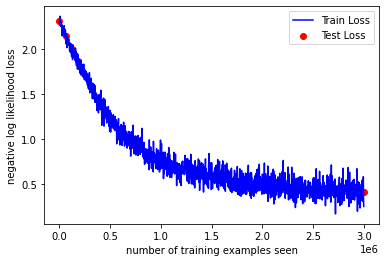

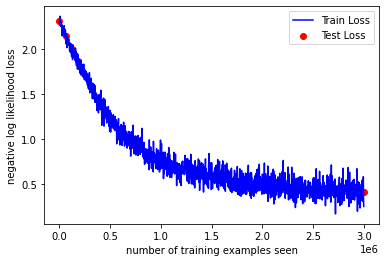

In [13]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
print(test_counter)
plt.scatter(test_counter, test_losses, color='red')


plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig